<a href="https://colab.research.google.com/github/BautistaDavid/Twitter_Posts/blob/main/Gif_Scatterplot/gif_scatterplot_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importamos Modulos A Usar


La lógica detrás de la creación del gif de el scatterplot es la creación de todos las escenas que componen al gif en formato png, de modo que simplemente tenemos que importar los módulos que nos servirían para realizar la visualización que deseemos, después de estos nos ayudaremos del modulo `imageio` para la creación de la “animación”.

In [2]:
# Modulos  para manejo de datos
import numpy as np 
import pandas as pd 

# Modulo para generar parametros de la funcion de relación
from sklearn.linear_model import LinearRegression

# Modulos para graficar 
import seaborn as sns
import matplotlib.pyplot as plt

# Modulo para la creación del gif 
import imageio


## Manejo De Los Datos

Como vamos a trabajar sobre dos tablas similares ya que provienen de la misma fuente (Banco Mundial), vamos a crear una sola función para arreglar y manejar los datos de las tablas, después de eso vamos a hacer un merge entre estas tablas y otra adicional llamada regiones, la cual nos permitirá acceder a información a los continentes específicos de cada país, esto con el fin de agregar información al grafico que vamos a construir.

Puede descargar los archivos originales desde el portal del [Banco Mundial](https://datos.bancomundial.org/) o acceder a los archivos modificados que se usaron en este proyecto directamente desde el [repositorio de GitHub](https://github.com/BautistaDavid/Twitter_Posts/tree/main/Gif_Scatterplot)


In [3]:
def compilador_datos(data:str) -> pd.DataFrame:
  ''' data: path del archivo csv a transformar'''

  # leemos el archivo con los datos
  df = pd.read_csv(data, encoding='latin1',on_bad_lines='skip',sep=';')

  # Modificamos los nombres de las columnas 
  df.columns = ['country','code'] + [str(año) for año in range(1990,2021)]

  # transformamos los valores numericos que estan en string 
  for col in [str(año) for año in range(1990,2021)]:
    df[col] = df[col].str.replace(',','.')
    df[col] = pd.to_numeric(df[col],errors='coerce')
  
  df = df.dropna()

  return df
  

In [6]:
# Creamos el dataframde regiones usando datos publicados por el usuario lukes en su github.
regiones = pd.read_csv('https://raw.githubusercontent.com/lukes/ISO-3166-Countries-with-Regional-Codes/master/all/all.csv')
regiones = regiones[['name','alpha-3','region','sub-region']]
regiones.columns = ['country','code','region','sub_region']

# Ahora usamos la funcion que creamos para proecesar los datos de esperanza de vida y pib per cápita.
esperanza = compilador_datos('https://raw.githubusercontent.com/BautistaDavid/Twitter_Posts/main/Gif_Scatterplot/Esperanza_vida.csv')
per_capita = compilador_datos('https://raw.githubusercontent.com/BautistaDavid/Twitter_Posts/main/Gif_Scatterplot/per_capita.csv')

 Visualicemos las tablas creadas hasta el momento:


In [7]:
esperanza.head(3)

,country,code,1990,1991,1992,1993,1994,1995,1996,1997,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Aruba,ABW,73.468,73.509,73.544,73.573,73.598,73.622,73.646,73.671,...,75.158,75.299,75.441,75.583,75.725,75.868,76.010,76.152,76.293,76.434
1,Afganistán,AFG,50.331,50.999,51.641,52.256,52.842,53.398,53.924,54.424,...,61.553,62.054,62.525,62.966,63.377,63.763,64.130,64.486,64.833,65.173
2,Angola,AGO,45.306,45.271,45.230,45.201,45.201,45.246,45.350,45.519,...,56.330,57.236,58.054,58.776,59.398,59.925,60.379,60.782,61.147,61.487


In [8]:
per_capita.head(3)

,country,code,1990,1991,1992,1993,1994,1995,1996,1997,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Aruba,ABW,21942.267490,23554.172810,24156.033900,24978.226170,26089.472260,26084.334980,25944.406820,27511.335930,...,35513.081190,34632.951650,36830.156610,36782.227120,37314.564390,37587.065940,38893.960560,40143.000270,39834.223900,31182.833880
2,Angola,AGO,3263.334350,3295.730956,3071.610764,2313.921780,2318.952828,2636.525014,2952.011249,3119.365502,...,6710.750725,7412.967137,7682.475646,8179.297828,7337.569901,7103.226249,7310.896551,7148.933253,6995.299736,6478.332182
3,Albania,ALB,2549.708941,1909.290810,1823.476534,2057.661495,2290.109912,2666.042365,2980.374617,2717.644348,...,10207.767570,10526.259180,10570.963730,11259.267510,11658.905520,12078.843140,12770.964290,13498.138170,13999.423970,13632.186540


In [9]:
regiones.head(3)

,country,code,region,sub_region
0,Afghanistan,AFG,Asia,Southern Asia
1,Åland Islands,ALA,Europe,Northern Europe
2,Albania,ALB,Europe,Southern Europe


Ahora modificaremos las tablas `esperanza` y `per_capita` para que cada año en cada país corresponda una sola observación y queden configurados como datos de tipo panel, esto lo haremos usando la función `pd.melt()`. 


Después de eso crearemos algunas columnas adicionales para poder establecer los parámetros de la función de relación entre las variables de esperanza de vida y PIB per cápita. Adicionalmente realizaremos los merge de las tablas y visualizaremos el resultado.


In [10]:
df1 = pd.melt(esperanza,id_vars=['country','code'],value_vars=[str(i) for i in range(1990,2021)],var_name='year',value_name='esperanza')

df2 = pd.melt(per_capita,id_vars=['country','code'],value_vars=[str(i) for i in range(1990,2021)],var_name='year',value_name='per_capita')

df = pd.merge(df1,df2,on=['country','code','year'],how='outer')
df_ = df.dropna()
df_ = df_.merge(regiones,on=['code'],how='outer').dropna().drop(columns=['country_y'])
df_.columns = ['country','code','year','esperanza','per_capita','Region','sub_region']
df_['per_capita'] = df_['per_capita']/1000
df_['log_per_capita'] = np.log10(df_['per_capita'])
df_['Region'] = df_['Region'].replace({'Americas':'America'})

df_.head()

,country,code,year,esperanza,per_capita,Region,sub_region,log_per_capita
0,Aruba,ABW,1990,73.468,21.942267,America,Latin America and the Caribbean,1.341282
1,Aruba,ABW,1991,73.509,23.554173,America,Latin America and the Caribbean,1.372068
2,Aruba,ABW,1992,73.544,24.156034,America,Latin America and the Caribbean,1.383026
3,Aruba,ABW,1993,73.573,24.978226,America,Latin America and the Caribbean,1.397562
4,Aruba,ABW,1994,73.598,26.089472,America,Latin America and the Caribbean,1.416465


## Creación De La Grafica Base.


Para la creación de la grafica base lo ideal sería crearla usando funciones que reciban un año en específico, esto con el fin de simplemente realizar un bucle con todos los años que van a conformar el gif, recordemos que el objetivo es crear tantos archivos png queramos para que sean cada escena del gif. Primero crearemos una función que calculara los coeficientes de una línea de regresión entre las variables esperanza de vida y PIB per cápita, después una que le da forma y estilo a al grafica. 


In [14]:
def regresion(df):
  y = df['esperanza'].to_numpy().reshape(-1,1)
  X = df['log_per_capita'].to_numpy().reshape(-1,1)
  reg = LinearRegression().fit(X,y)
  return {'parametro':reg.coef_,'intercepto':reg.intercept_}

In [17]:
def grafica_(año):

  # filtramos las observasciones para todos los paises en un solo año 
  df = df_[df_['year']==año]
  
  # Cargamso los datos de la linea de regresion 
  parametro = regresion(df)['parametro'][0][0]
  intercepto = regresion(df)['intercepto'][0]

  # Empezamos a contruir la grafica 

  X = np.linspace(0.1,58,100) # cremos una arreglo con numpy para graficar la funcion de regresion
  sns.set_theme()     # fijamos un tema de estilo de seaborn
  
  plt.figure(figsize=(11,7))  # Le damos dimensiones a la figura 
  plt.title(f'Relación Esperanza de Vida y PIB Per Cápita\n ',fontsize=25,loc='left') # configuramos el titulo
  
  plt.plot(X,intercepto + parametro * np.log10(X),c='black',linestyle='--') # Graficamos la linea de regresion  
  sns.scatterplot(data=df,x='per_capita',y='esperanza',hue='Region',s=50) # Graficamos el scatterplot
  
  plt.xlabel('\nPIB PER CÁPITA (Miles de USD)\n \n ',fontsize=16)  # configuramos lable del eje x 
  plt.ylabel('Esperanza de Vida (Años)\n ',fontsize=16)   # configuramos lable del eje y
 
  plt.xticks(size=15)  # configuramos tamaño de las unidades del eje x 
  plt.yticks(size=15)  # configuramos tamaño de las unidades del eje y 
  
  plt.ylim(30,90)     # Configuramos limites de visualizacion del eje x 
  plt.xlim(0,58)      # Configuramos limites de visualizacion del eje x

  plt.legend(loc='lower right',borderpad=1,fontsize=14) # configuramos el cuadro de las leyendas del grafico
  
  # Creamos un suptiulo y textos para agregar informacion adicional al grafico 
  plt.suptitle('PIB Per Cápita en USD PPA, Datos: Banco Mundial *',x=0.365,y=0.92) 
  plt.text(x=30.25,y=42,s=f'{año}',fontsize=40)
  plt.text(x=45,y=15,s='Autor: David Bautista\n          @PipeBau_')

  # Guardamos la figura, notese que el nombre tambien conforma una estructura de iteracion por año
  plt.savefig(f'grafica_{año}.png',dpi=100, bbox_inches='tight')
  plt.show()




Vamos a probar como se vería cada grafica usando un bucle, así pues las imágenes ya quedarán guardadas en el directorio.


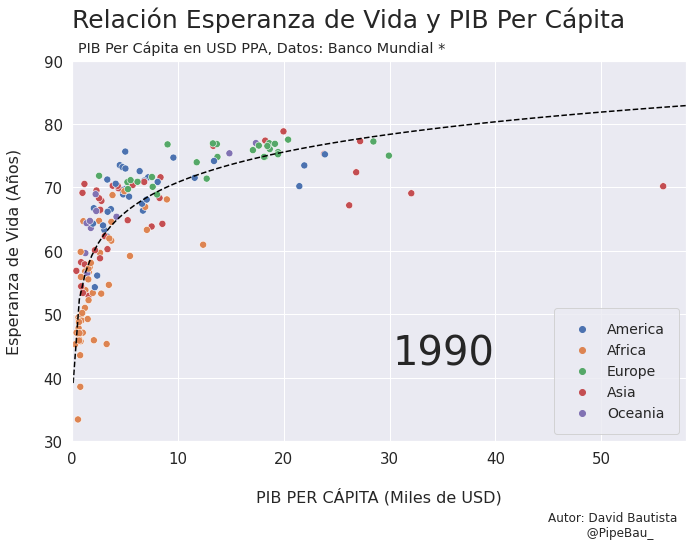

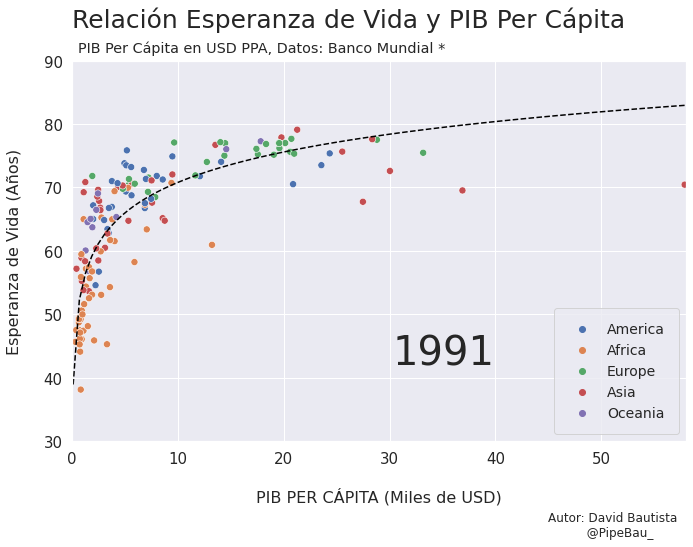

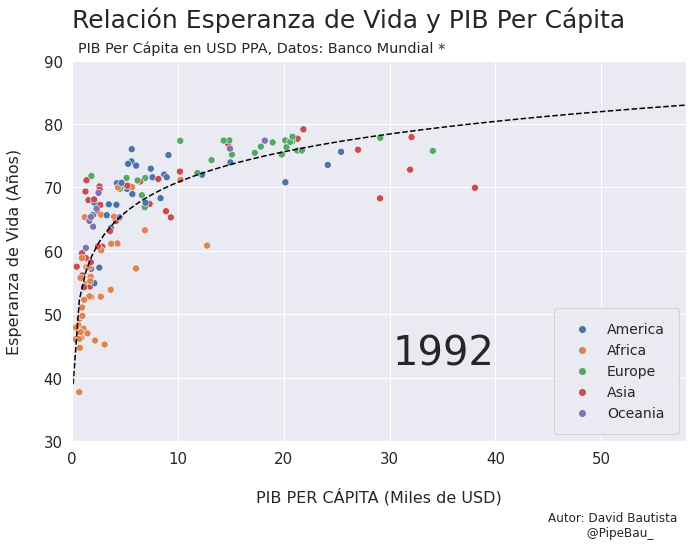

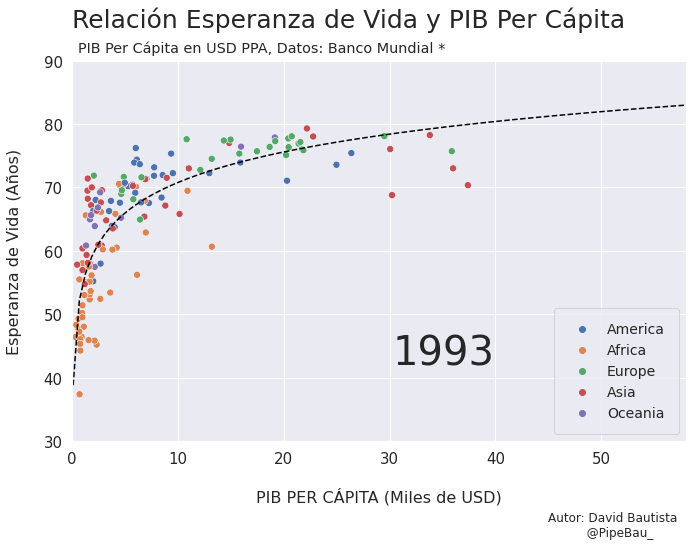

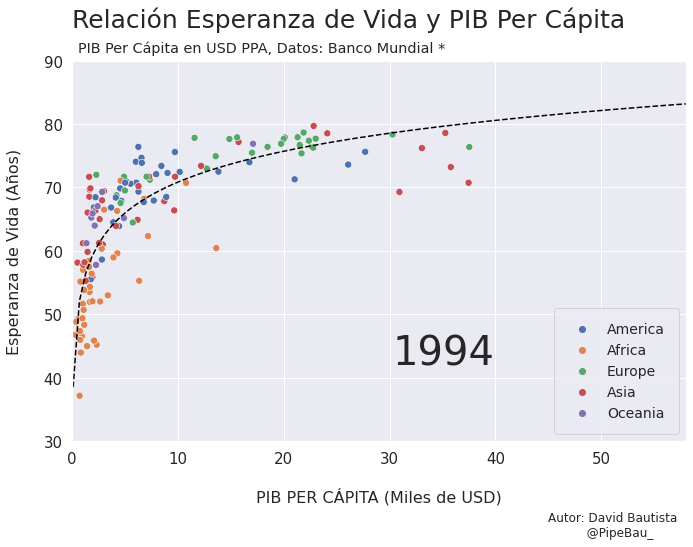

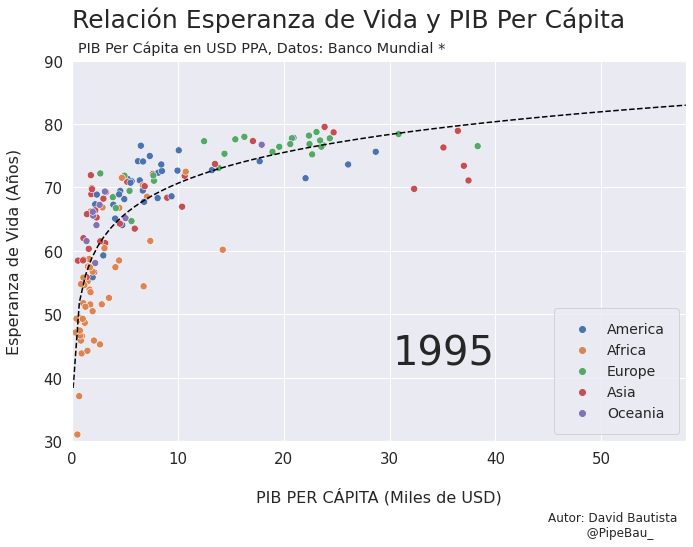

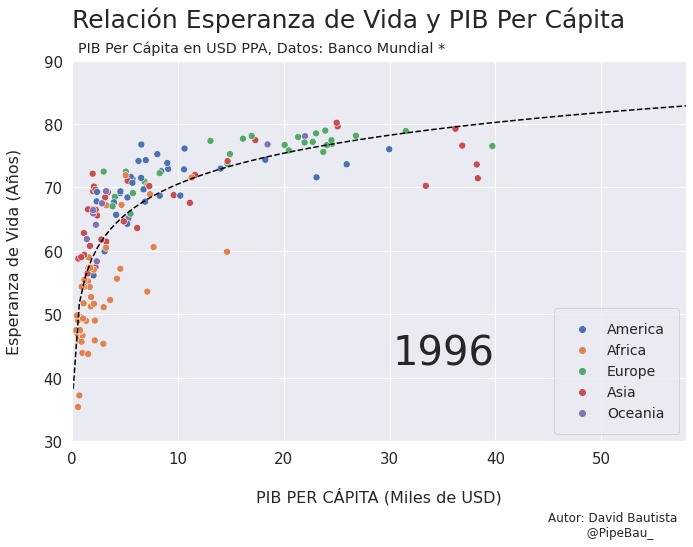

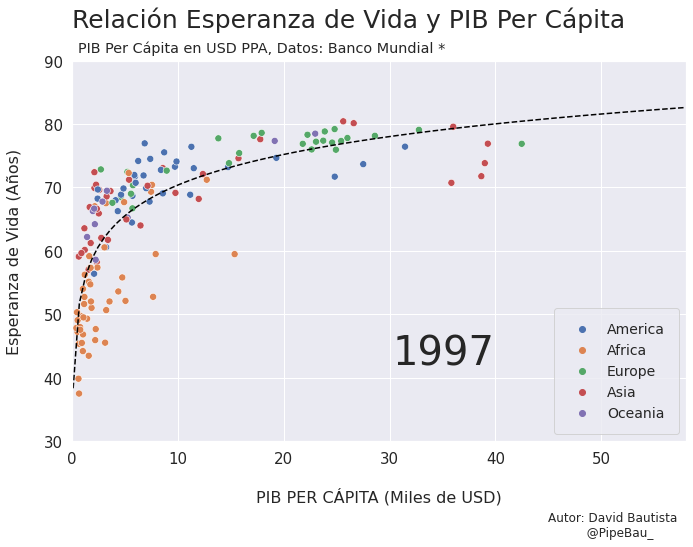

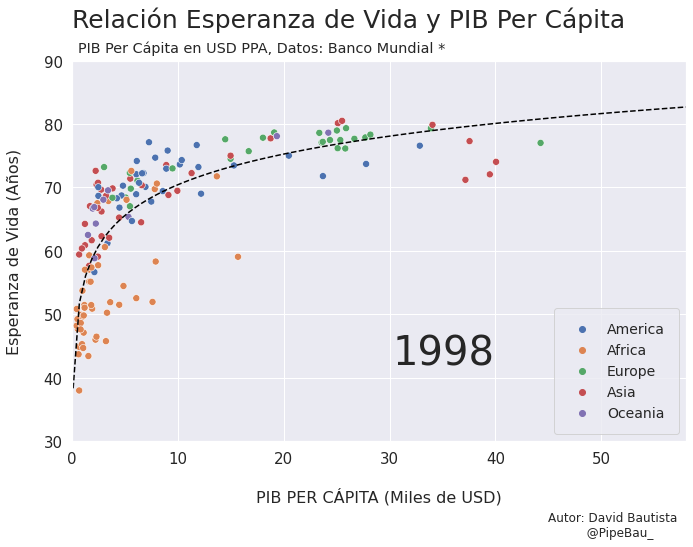

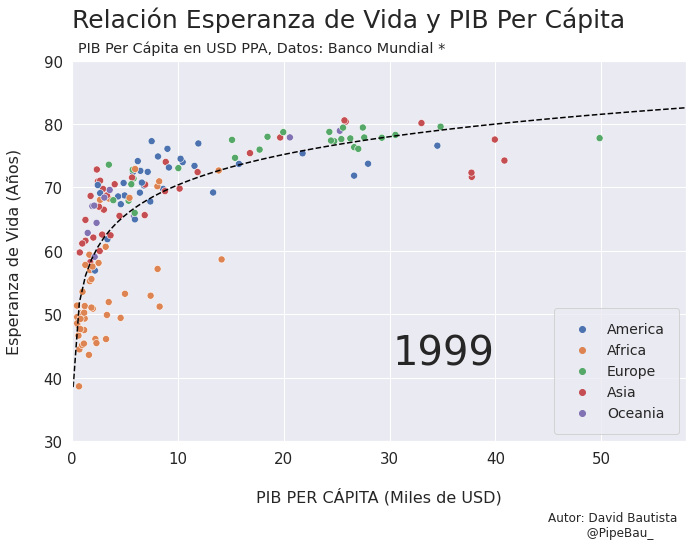

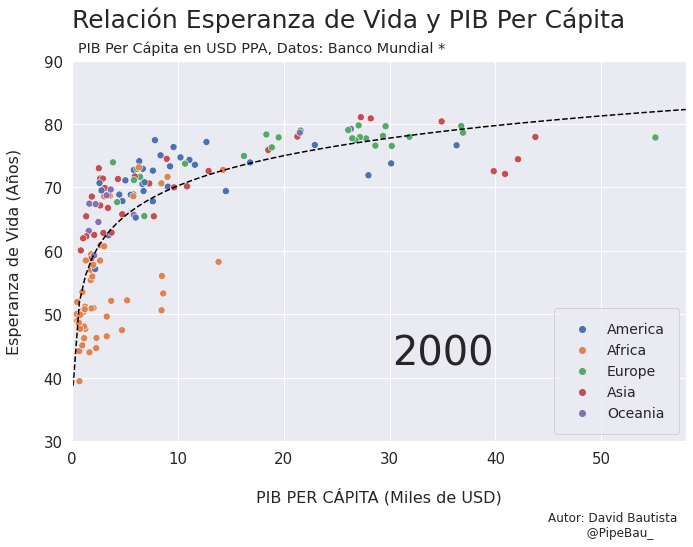

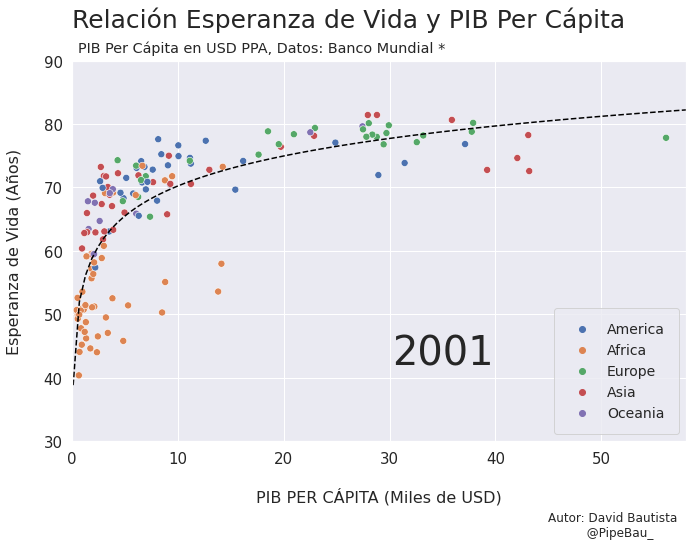

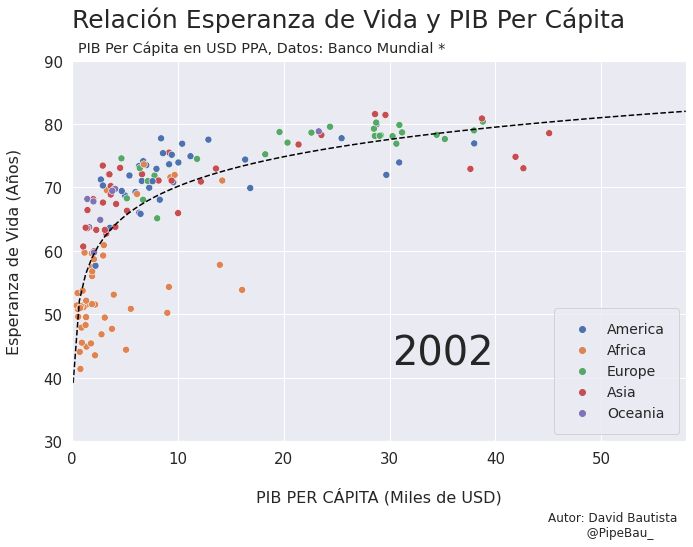

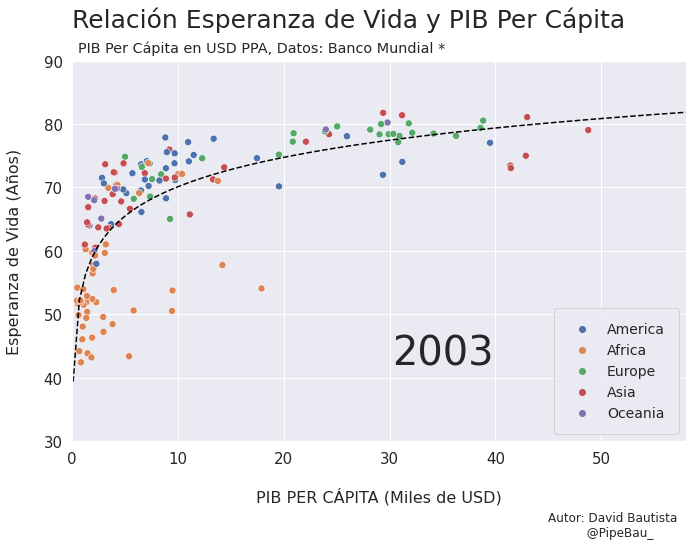

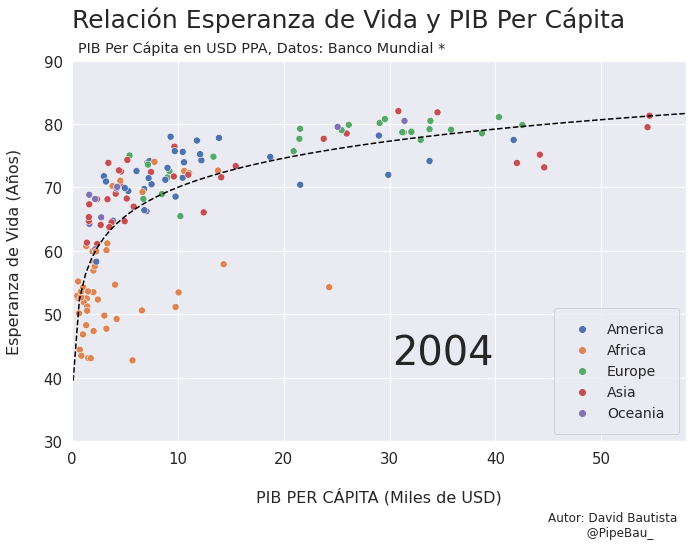

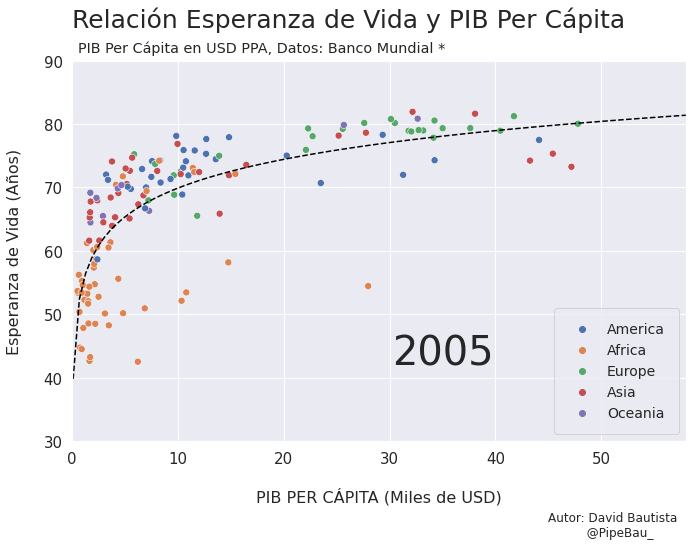

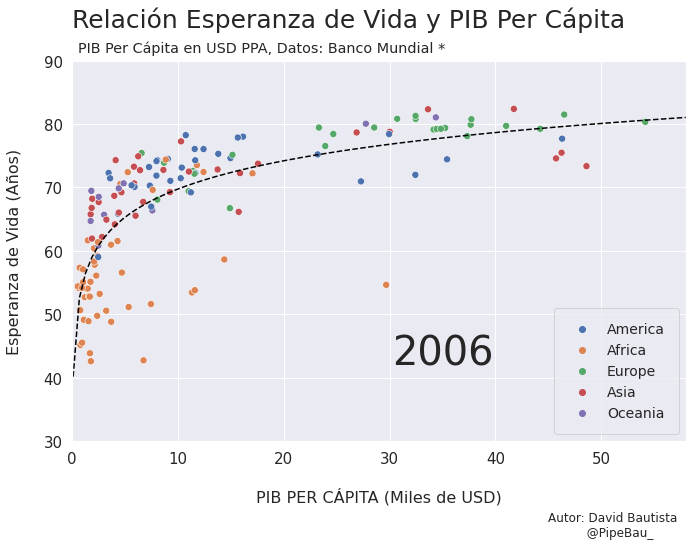

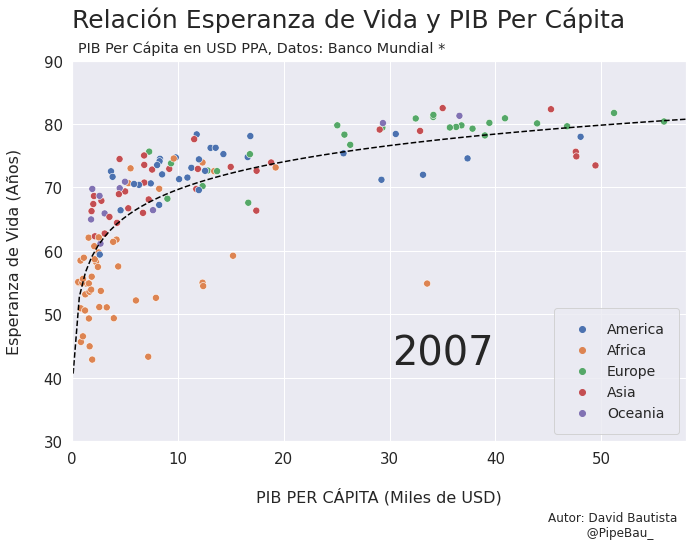

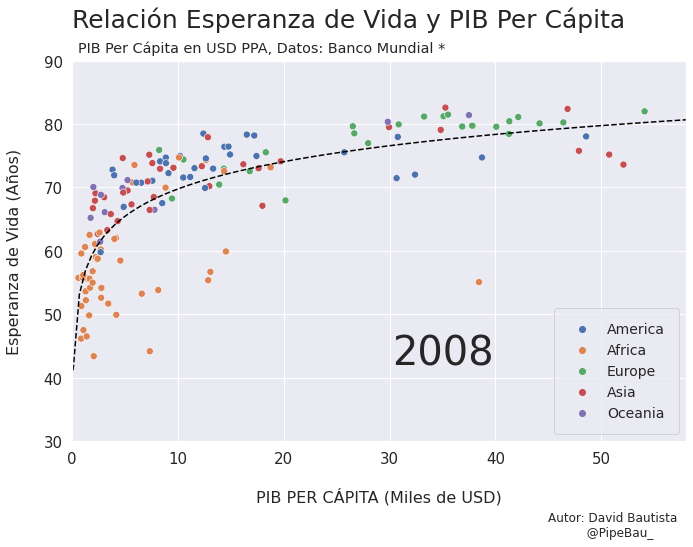

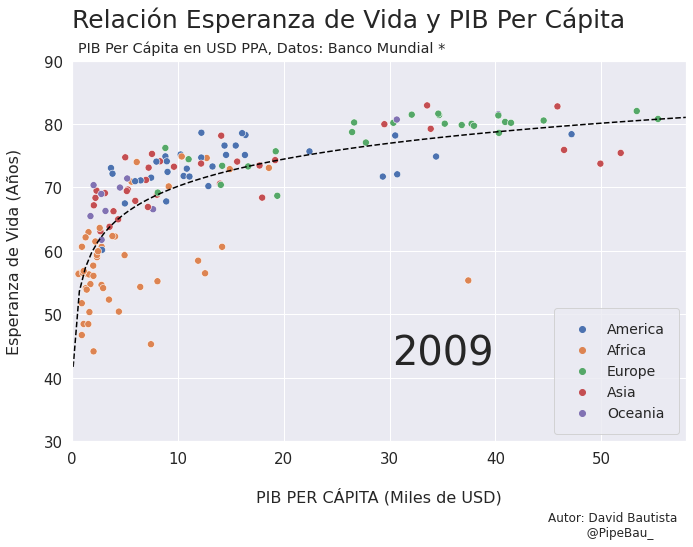

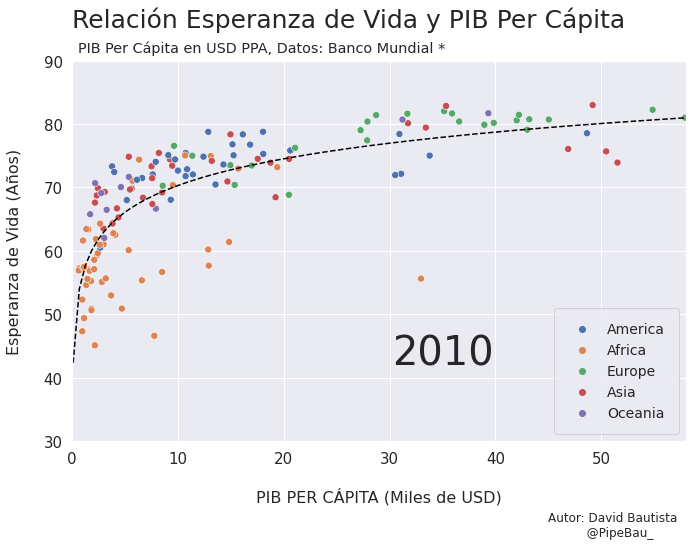

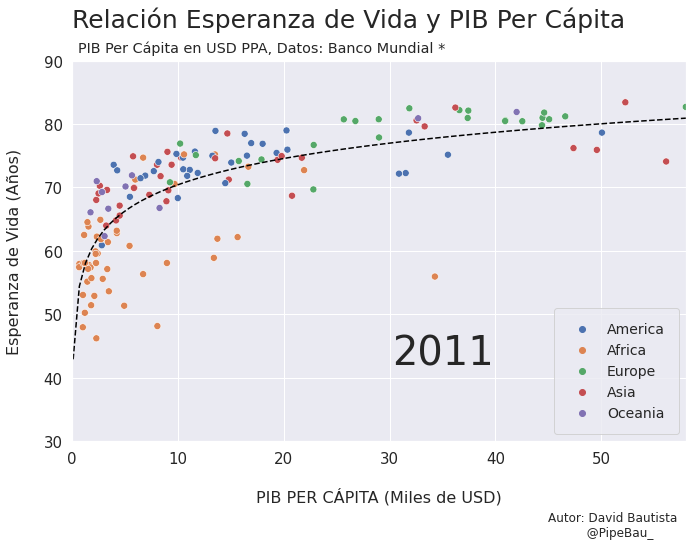

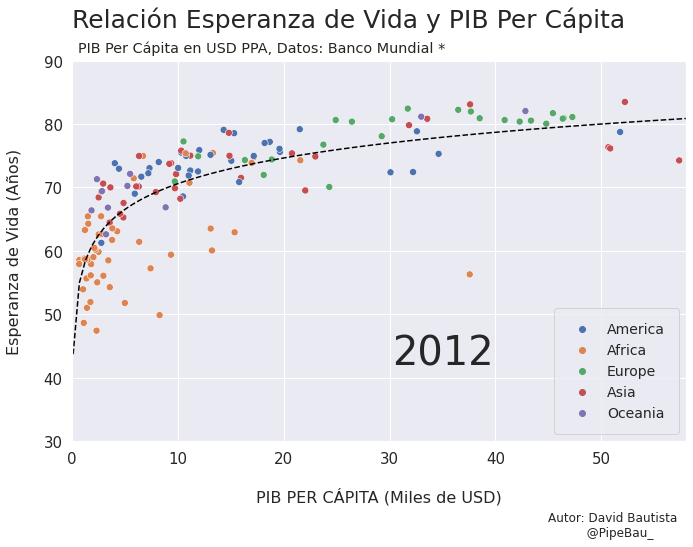

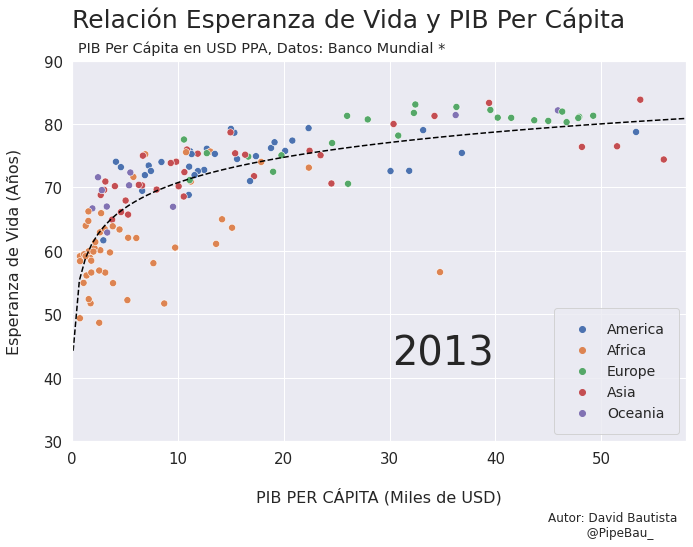

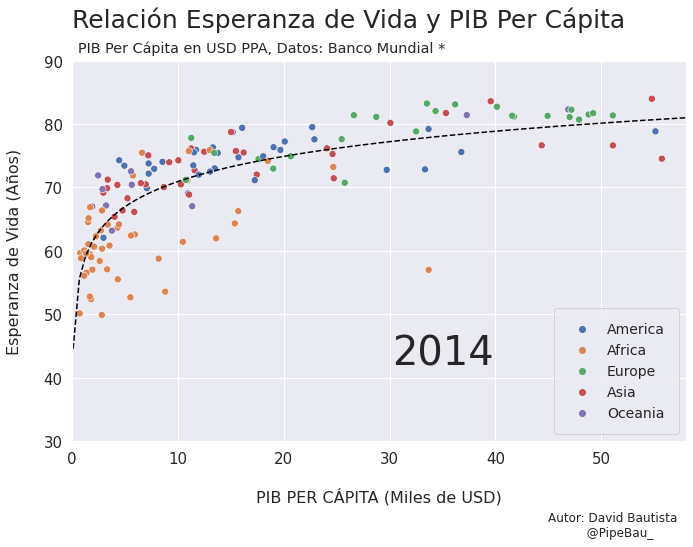

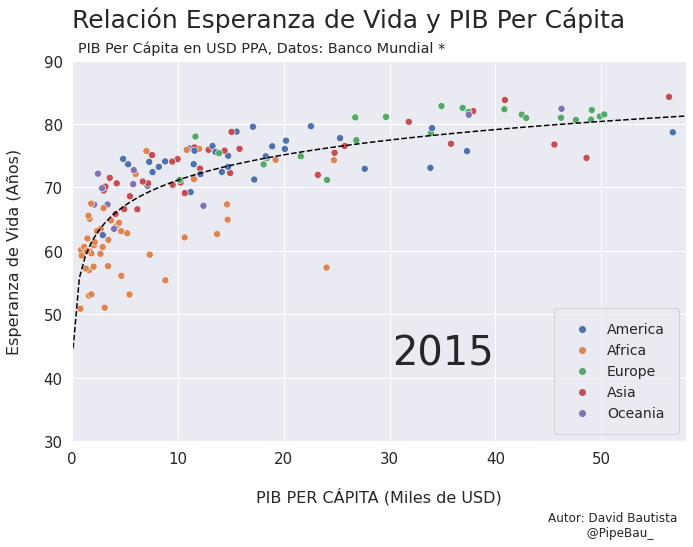

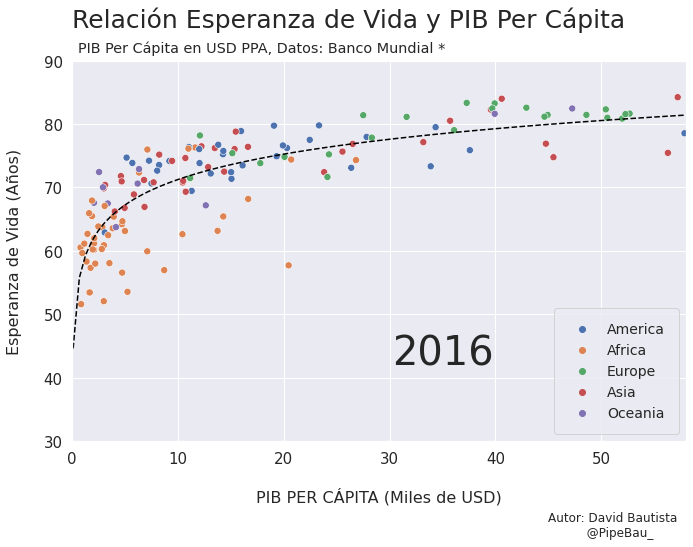

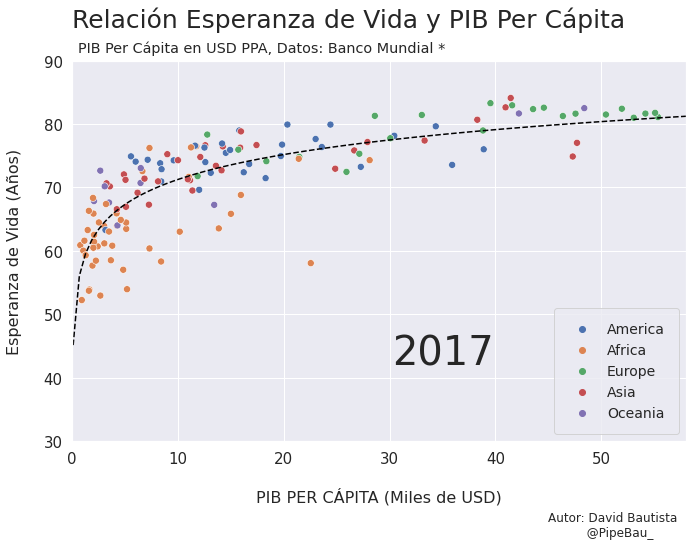

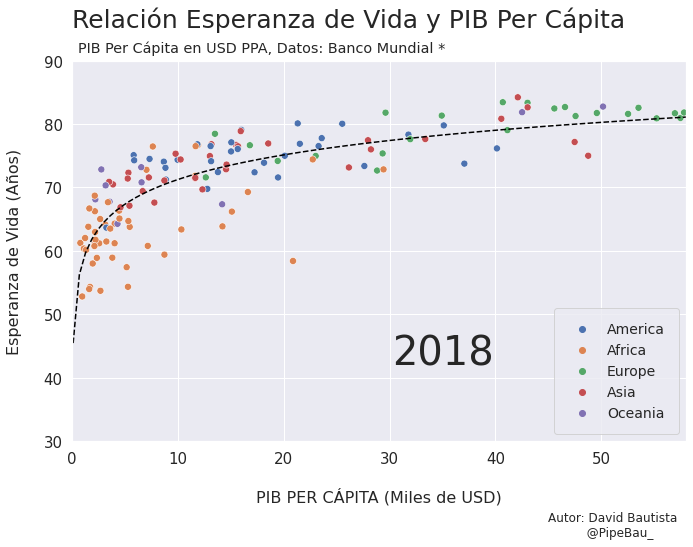

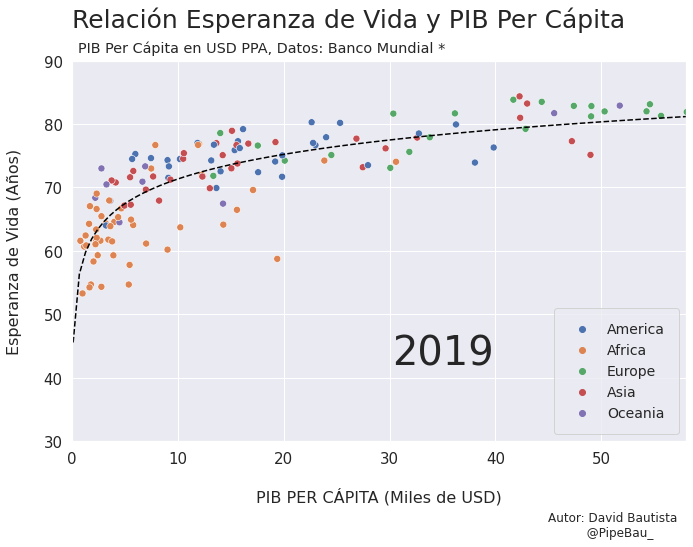

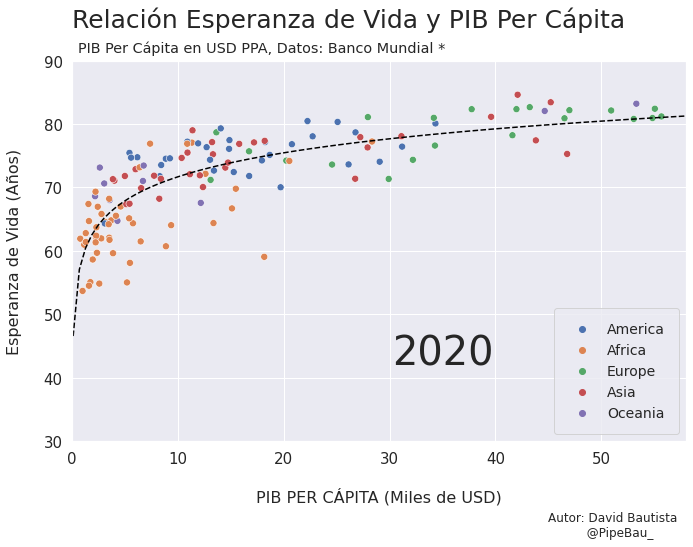

In [18]:
for año in [str(j) for j in range(1990,2021)]:
  grafica_(año)

## Contruyamos El Gif!!! 


Ahora usamos una estructura básica del módulo imageio para “escribir” el gif con todas las imágenes que ya están en sistema por medio de un bucle.  


In [19]:
import imageio
with imageio.get_writer('scatter.gif', mode='i',duration=0.5) as writer:
    for i in range(1990, 2021):
        image = imageio.imread(f'grafica_{i}.png')
        writer.append_data(image)

<!DOCTYPE html>
<html>
   <head>
      <title> </title>
   </head>
   <body>
      <h1>Resultado:</h1>
      <img src="https://raw.githubusercontent.com/BautistaDavid/Twitter_Posts/main/Gif_Scatterplot/scatter.gif">
   </body>
</html>